# Quantum search algorithm: Grover's algorithm

> Quantum Mechanics Helps in Searching for a Needle in a Haystack
>
>PHYSICAL REVIEW LETTERS 1997
>
>by Lov K. Grover
>
>[arXiv [link](https://arxiv.org/abs/quant-ph/9706033)]
>

Grover's Algorithm is an [oracle](https://codebook.xanadu.ai/A.2)-based quantum
algorithm, proposed by [Lov Grover](https://arxiv.org/abs/quant-ph/9706033) in 1996.

Suppose you are given a strange Boolean function which is almost constant, except for a single integer input value $\omega$ where it does something different:
(ago in un pagliaio)

$$ f : \{0, 1\}^n \rightarrow \{0, 1\} $$

$$
f(x)=
\begin{cases}
    1              & x = \omega,\\
    0              & \text{otherwise}
\end{cases}
$$

In other words, the problem is defined by searching for an item on a list with $N$ items, given
an *Oracle* (or black box) access function $f(x)$, where as usual we defined the integer $x = \sum_{j=0}^{n-1} x_j 2^j
$.

> NB: An oracle is able to recognize $\omega$ when given as an input, but it cannot be asked for the answer or reverse-engineered

In the original abstract formulation, the author approaches the
following problem: suppose that we are searching for a *single* specific phone number $\omega$ in a randomly-ordered
catalogue containing $N$ entries.

It is an **unstrctured dataset**: there is no better algorithm than brute-force search.

* To find such a number with a probability of
$\frac{1}{2}$, a classical algorithm will need to check the list on average
$\frac{N}{2}$ times.

* To be sure to find it, in the worst-case scenario, you need to call the oracle function $f(x)$ a total of $N$ times


> The solution to this black-box search problem with a quantum algorithm enables to perform $O(\sqrt{N})$ queries to a **quantum oracle**
> in the framework of a probabilistic algorithm that finds the answer $\omega$ with high probability.



### How to define a quantum oracle?

1. Define the invertible version of $f(x)$ in the context of classical *reversible computation* with the XOR $\oplus$:
$$
\tilde{f} : \{0, 1\}^{n+1} \rightarrow \{0, 1\}^{n+1} \ \ \ \text{ with } \ \ \ \tilde{f}(x, y) = (x, y \oplus f(x))
$$

The first $n$ bit are the **input register** while the last qubit is the output or **ancilla** register (can be easily extended to $m$ ancilla qubits if f : \{0, 1\}^n \rightarrow \{0, 1\}^m).

> Show that (trivial) $\tilde{f}^{-1} = \tilde{f}$ and note that $\tilde{f}(x, 0) = (x, f(x))$

2. Extend this invertible function to a quantum unitary operator: it is defined on the computational basis, so it is immediately extended via linearity and it is **unitary** (it performs a permutation of the orthonormal computational basis of n+1 qubits, i.e. a change of orthonormal basis, hence it is unitary).

$$
U_f (\left| x \right\rangle_n \otimes \left| y \right\rangle) = \left| x \right\rangle_n \otimes \left| y \oplus f(x) \right\rangle
$$



> Show that (very simple): $ U_f \big( \left| x \right\rangle_n \otimes (\mathrm{H} \left| 1 \right\rangle) \big) =  (-1)^{f(x)}\left| x \right\rangle_n \otimes (\mathrm{H}\left| 1 \right\rangle) $


Let us now **fix** the ancilla qubit in $\mathrm{H} \left| 1 \right\rangle)$. We restrict the unitary $U_f$ to the input register with $n$ qubits: call it $V$.

For the Grover search this results in the unitary operator:

$$
V \vert{x}\rangle = (-1)^{f({x})}\vert x\rangle =
\begin{cases}
    -\vert {x}\rangle              & {x} = {\omega},\\
    \vert {x}\rangle              & \text{otherwise}
\end{cases}$$

Equivalently, we can write the operator $V$ in terms of bras and kets:

$$V = \mathbb{I} - 2\vert{\omega}\rangle\langle {\omega}\vert $$



In this tutorial, we implement a search for an n-bit string item $\vert{\omega} \rangle$ using a quantum
circuit based on Grover's Algorithm.

The algorithm can be broken down into the following steps:

1. Prepare the initial state

2. Implement the Oracle

3. Apply the Grover diffusion operator

4. Repeat steps 2 and 3  approximately $\frac{\pi}{4}\sqrt{N}$ times

5. Measure


Let's import the usual PennyLane and Numpy libraries to load the necessary functions:


### 1. Prepare the initial state

To perform the search, we need $n$ qubits, with an Hilbert space of dimension $N = 2^n$.
Each computational basis state $\vert x \rangle = \vert x_{n-1} \dots x_1 x_0$ is represented via N binary numbers and corresponds to a candidate solution of the Grover search

As usual, we initialize the system in the uniform superposition over all states, i.e.:

$$ |s\rangle ={\frac {1}{\sqrt {N}}}\sum _{x=0}^{N-1}|x\rangle = \vert + \rangle^{\otimes N} $$

This can be achieved by applying a Hadamard gate to all the qubits.


We can inspect the circuit using `Snapshot` to see how the states change on each step of the algorithm.

Let us consider $n=3$ qubits.

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

In [3]:
NUM_QUBITS = 3
dev = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))

def equal_superposition(wires):
    for j in wires:
        qml.Hadamard(wires=j)

@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state") # the argument is the key of the dictionary (see below)
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    return qml.probs(wires=wires)  # Probability of finding a computational basis state on the wires


results = qml.snapshots(circuit)() # returns a dictionary with the snapshots of a qnode

for k, result in results.items():
    print("\n")
    print(f"{k}: {result}")



Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


After applying the Hadamard gates: [0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


execution_results: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


We may use a bar plot to visualize the initial state *real* amplitudes.

As expected, they are equally distributed.

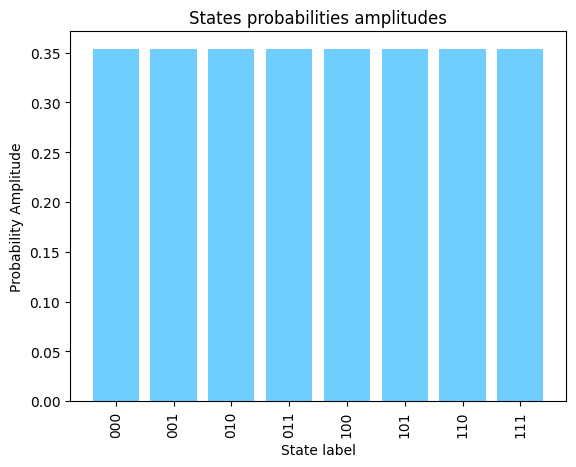

In [4]:
y = np.real(results["After applying the Hadamard gates"]) # retrieve the value of that key in the dictionary results
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))] # collection of the 2**NUM_QUBITS classical configurations

plt.bar(bit_strings, y, color = "#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")
plt.show()

### 2. Implement the Oracle

Recall that
$$V = \mathbb{I} - 2\vert{\omega}\rangle\langle {\omega}\vert $$

Let us suppose fer definiteness that the unique solution is the bit string $101$ and therefore the computational basis element $\vert\mathbf{\omega}\rangle = \vert101\rangle$.

The quantum oracle then turns out to be a matrix like the following (phase flip on $\vert\mathbf{\omega}\rangle$):

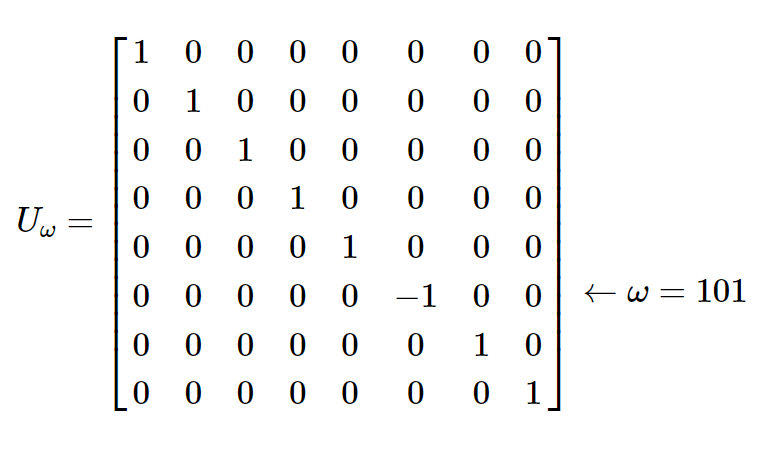


Let us try to build it by *supposing we already know the solution beforehand* (if you see a contradiction, you are right, more about this later on).

This can be easily implemented with [`FlipSign`](https://docs.pennylane.ai/en/stable/code/api/pennylane.FlipSign.html#pennylane.FlipSign), which takes a binary array and flips the sign of the corresponding state.


Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

After applying the Hadamard gates: [0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]

After flipping 101: [ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.35355339+0.j -0.35355339+0.j  0.35355339+0.j  0.35355339+0.j]

execution_results: [ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.35355339+0.j -0.35355339+0.j  0.35355339+0.j  0.35355339+0.j]


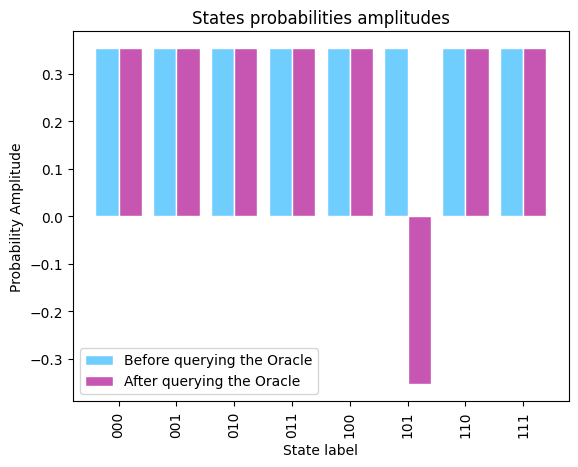

In [5]:
@qml.qnode(dev)
def circuit2():
    qml.Snapshot("Initial state") # the argument is the key of the dictionary (see below)
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    # Flipping the marked state
    qml.FlipSign([1, 0, 1], wires=wires)
    qml.Snapshot("After flipping 101")
    return qml.state()

results = qml.snapshots(circuit2)()

# again, print the snapshot dictionary
for k, result in results.items():
    print(f"\n{k}: {result}")

y1 = np.real(results["After applying the Hadamard gates"])
y2 = np.real(results["After flipping 101"])

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y1))]

bar_width = 0.4

rect_1 = np.arange(0, len(y1))
rect_2 = [x + bar_width for x in rect_1]

plt.bar(
    rect_1,
    y1,
    width=bar_width,
    edgecolor="white",
    color = "#70CEFF",
    label="Before querying the Oracle",
)
plt.bar(
    rect_2,
    y2,
    width=bar_width,
    edgecolor="white",
    color = "#C756B2",
    label="After querying the Oracle",
)

plt.xticks(rect_1 + 0.2, bit_strings, rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")
# plt.axhline(y=0.0, color="k", linestyle="-")

plt.legend()
plt.show()

Pennylane implements non-trivial gates for you. How would you construct the oracle $V$ as in FlipSign with elementary gates?

1. We can use a multi-controlled Z-gate to flip the last state $\vert 111 \rangle$.

2. We can use bit flip $X$ gates to choose another state to be flipped

[ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j -0.35355339+0.j]


/home/ronin/miniforge3/envs/quantum/lib/python3.12/site-packages/pennylane/ops/op_math/controlled_ops.py:1046: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


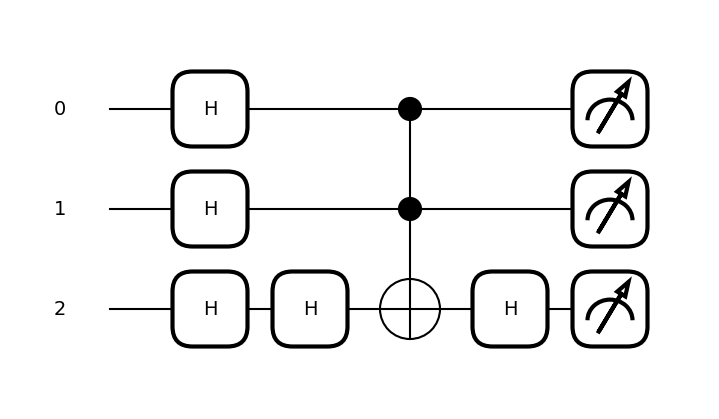

In [15]:
# Part 1.

def oracle():
    qml.Hadamard(wires=[2])
    qml.MultiControlledX(control_wires=[0,1], wires=[2])
    qml.Hadamard(wires=[2])


@qml.qnode(dev)
def circuit3():
    equal_superposition(wires)
    # Flipping the last state 111
    oracle()
    return qml.state()

print(circuit3())

fig, ax = qml.draw_mpl(circuit3)()

[ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.35355339+0.j -0.35355339+0.j  0.35355339+0.j  0.35355339+0.j]


/home/ronin/miniforge3/envs/quantum/lib/python3.12/site-packages/pennylane/ops/op_math/controlled_ops.py:1046: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


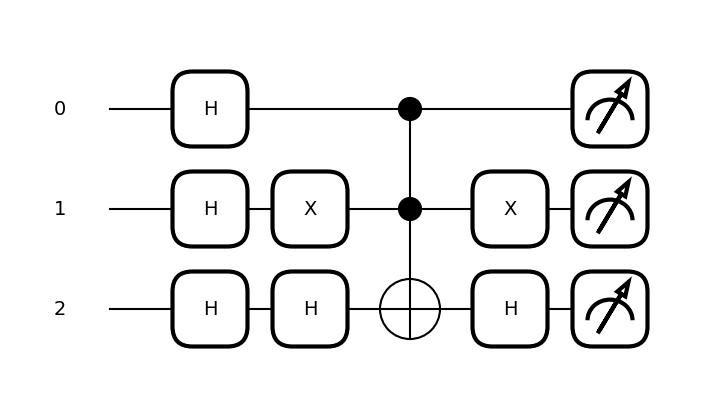

In [14]:
# Part 2.

def oracle_101():
    qml.PauliX(wires=[1])
    qml.Hadamard(wires=[2])
    qml.MultiControlledX(control_wires=[0,1], wires=[2])
    qml.Hadamard(wires=[2])
    qml.PauliX(wires=[1])

@qml.qnode(dev)
def circuit3():
    equal_superposition(wires)
    # Flipping the last state 101
    oracle_101()
    return qml.state()

print(circuit3())

fig, ax = qml.draw_mpl(circuit3)()


---
## Exercise 1

Construct an oracle for $\vert\mathbf{\omega}\rangle = \vert01100\rangle$ and verify it is correct by comparing the two procedures or drawing a bar plot

In [ ]:
# your code here

# hademard all, flipsign 01100

### 3 Apply the Grover diffusion operator

The uniform superposition state is not convenient since the probability of measuring the solution is exponentially small: $\frac{1}{\sqrt{2^n}}=\frac{1}{\sqrt{N}}$.

We woul like to shift amplitude into the solution state $\vert \omega \rangle$ using our oracle $V$ and possibly other operators.
This idea is called **amplitude amplification**.

> Grover's algorithm is important not so much for the end applications that quantum computing may have such as chemistry or finance but it is important for quantum computing itself. It is therefore often described as an ampitude amplification method that is useful as a subroutine to other algorithms.

You have seen the theory of Grover's algorithm.
An additional references I suggest for an in-depth and very clear cover of the subject: [S. Olivares lecture notes](https://sites.unimi.it/olivares/quantum-computing/).

Let us recall a few points:

$$\vert{s}\rangle = \frac{1}{\sqrt{N}}\sum_{{x}=0}^{N-1}\vert{x}\rangle$$

$$\vert{s}\rangle = \frac{1}{\sqrt{N}}\vert{\omega}\rangle + \frac{1}{\sqrt{N}}\sum_{{x}\neq{\omega}}\vert{x}\rangle = \frac{1}{\sqrt{N}}\vert{\omega}\rangle + \sqrt{\frac{N-1}{N}}\vert{s'}\rangle \equiv \sin(\theta) \vert{\omega}\rangle +  \cos(\theta) \vert{s'}\rangle $$

where $\vert{s'}\rangle = \frac{1}{\sqrt{N-1}}\sum_{{x}\neq{\omega}}\vert{x}\rangle$ is a normalized state in the $(N-1)$-dim eigenspace spanned by all computational basis state **but** $\vert \omega \rangle$.

By considering only $real$ lineal combinations of $\vert \omega \rangle$ and $\vert{s'}\rangle$ we can restrict to a fictitious $2$-dimensional real vector space and leverage graphical intuition.


The angle in the image is defined such that

$$\sin{\theta} = \frac{1}{\sqrt{N}}\implies \theta \sim \frac{1}{\sqrt{N}} \hspace{2mm} \text{for} \hspace{2mm} N \gg 0$$  

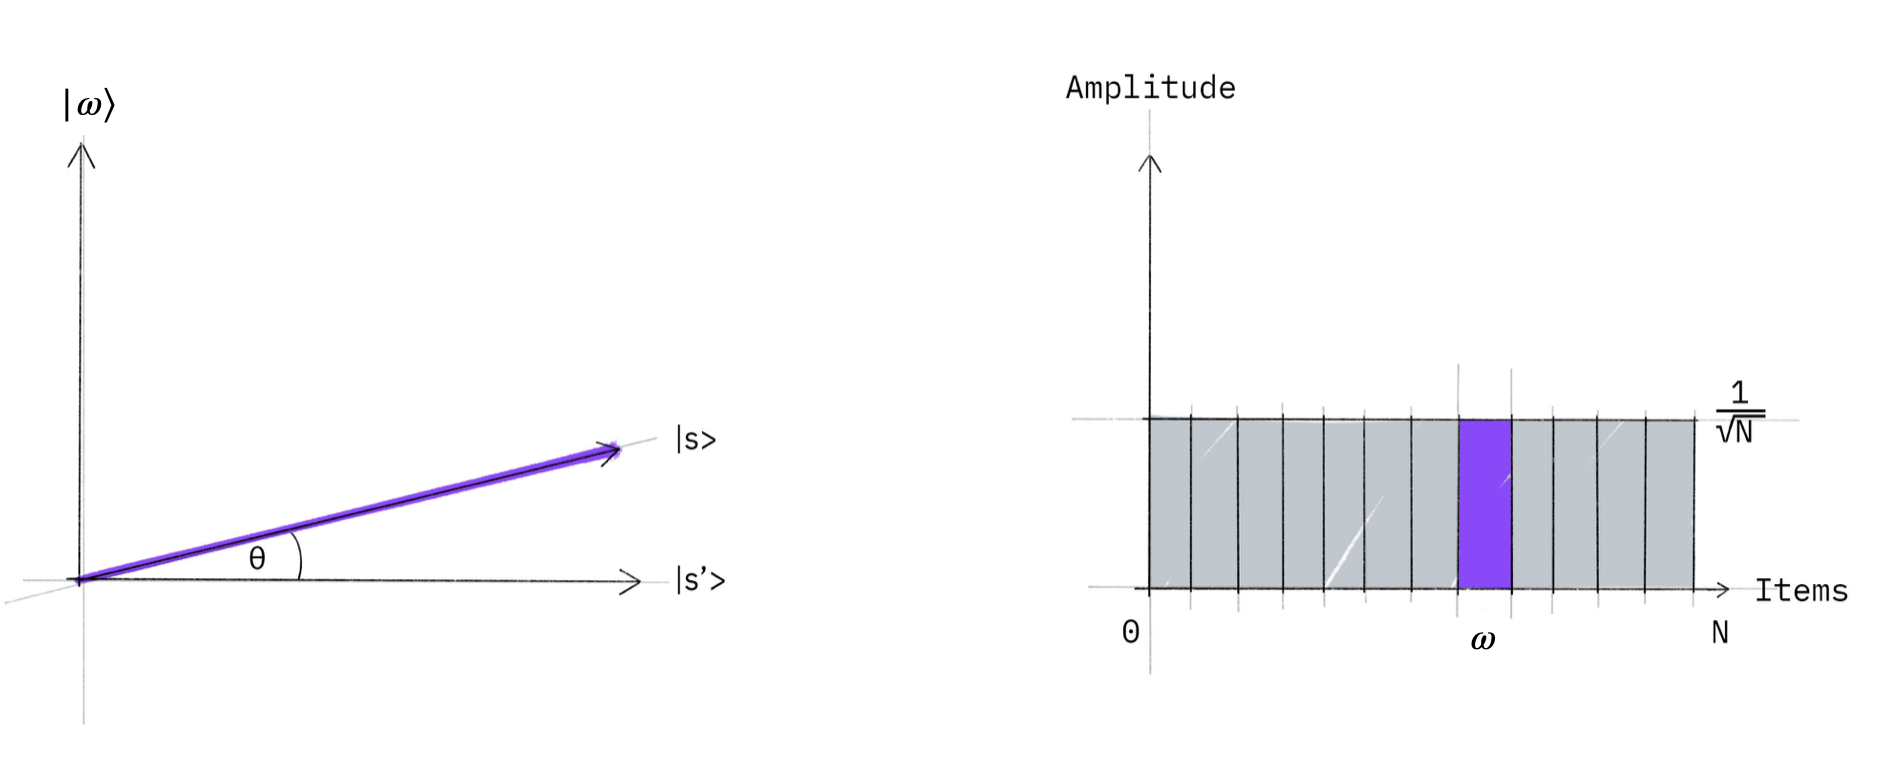

By applying the quantum oracle $V = \mathbb{I} - 2\vert{\omega}\rangle\langle {\omega}\vert $ we obtain a **reflection** across the $x$ axis of this fictitious space:

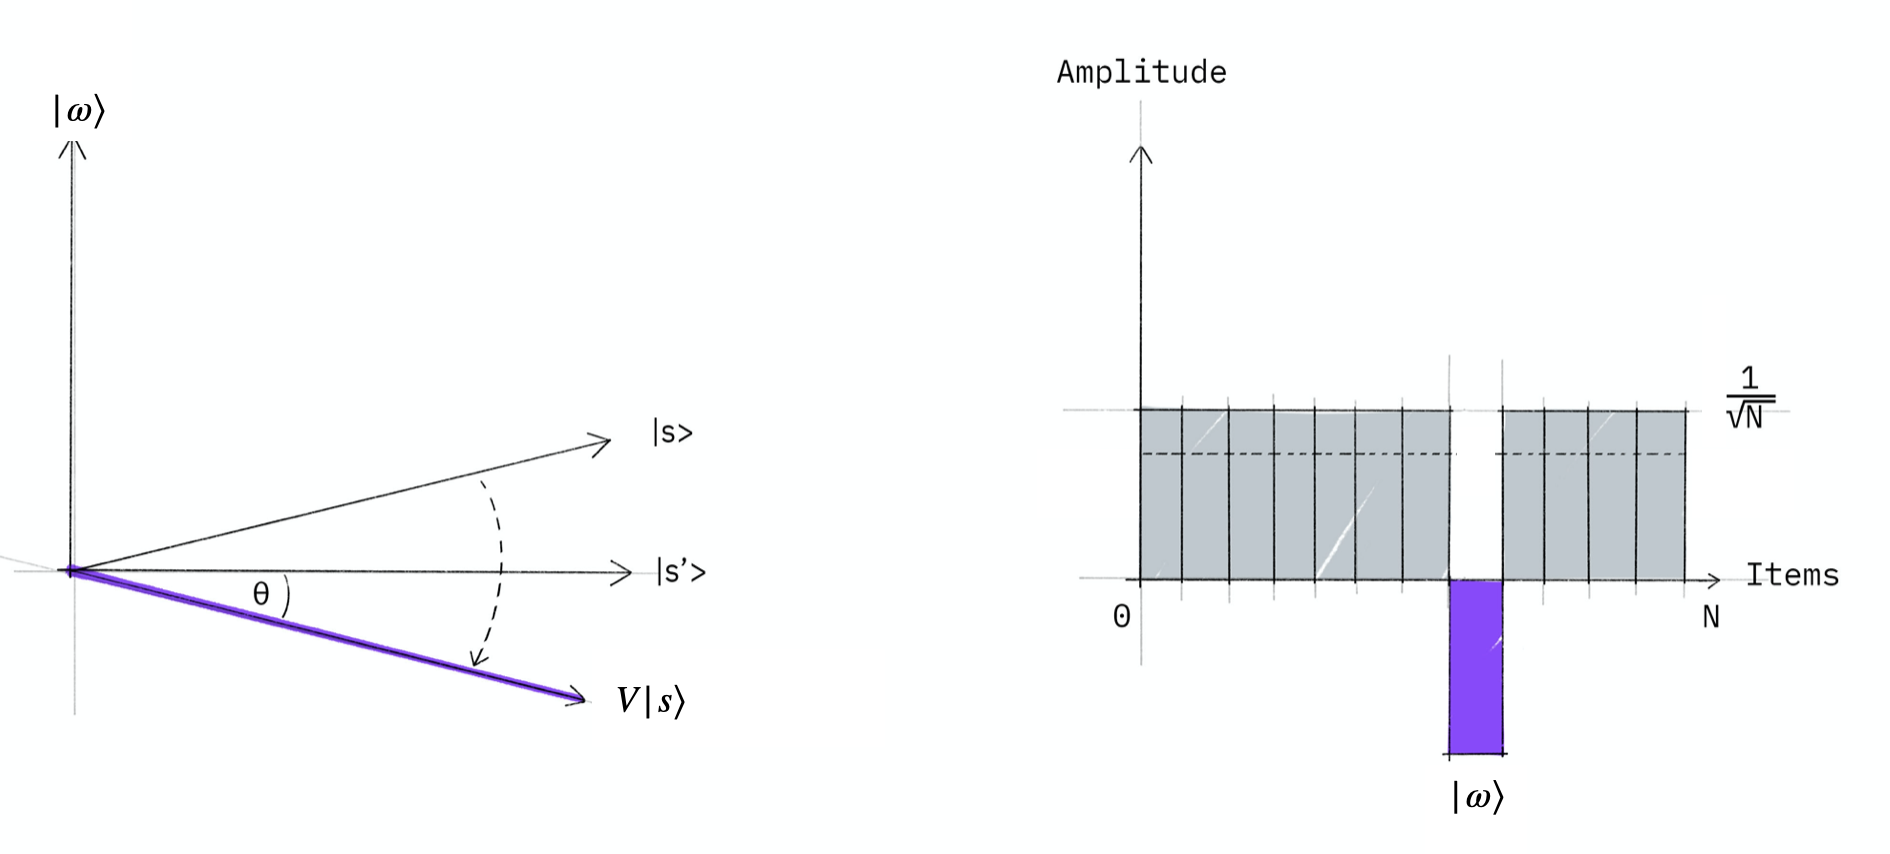


The brilliant idea by Grover is to invent a "kinetic term" or "diffusion operator" that does **not** contain any information on the unknown $\omega$ (it is "universal") and allows to rotate the system state closer and closer to the desired solution $\vert \omega \rangle$.

This operator is

$$ U_d = 2\vert{s}\rangle\langle{s}\vert - \mathbb{I} = H^{\otimes n} \big(2\vert{0}\rangle\langle{0}\vert - \mathbb{I}\big) H^{\otimes n} $$

It also results in a reflection, this time across the direction of the vector associated with the uniform superposition $\vert s \rangle$.

> Hint: prove this fact (pen and paper, by using the geometrical picture)

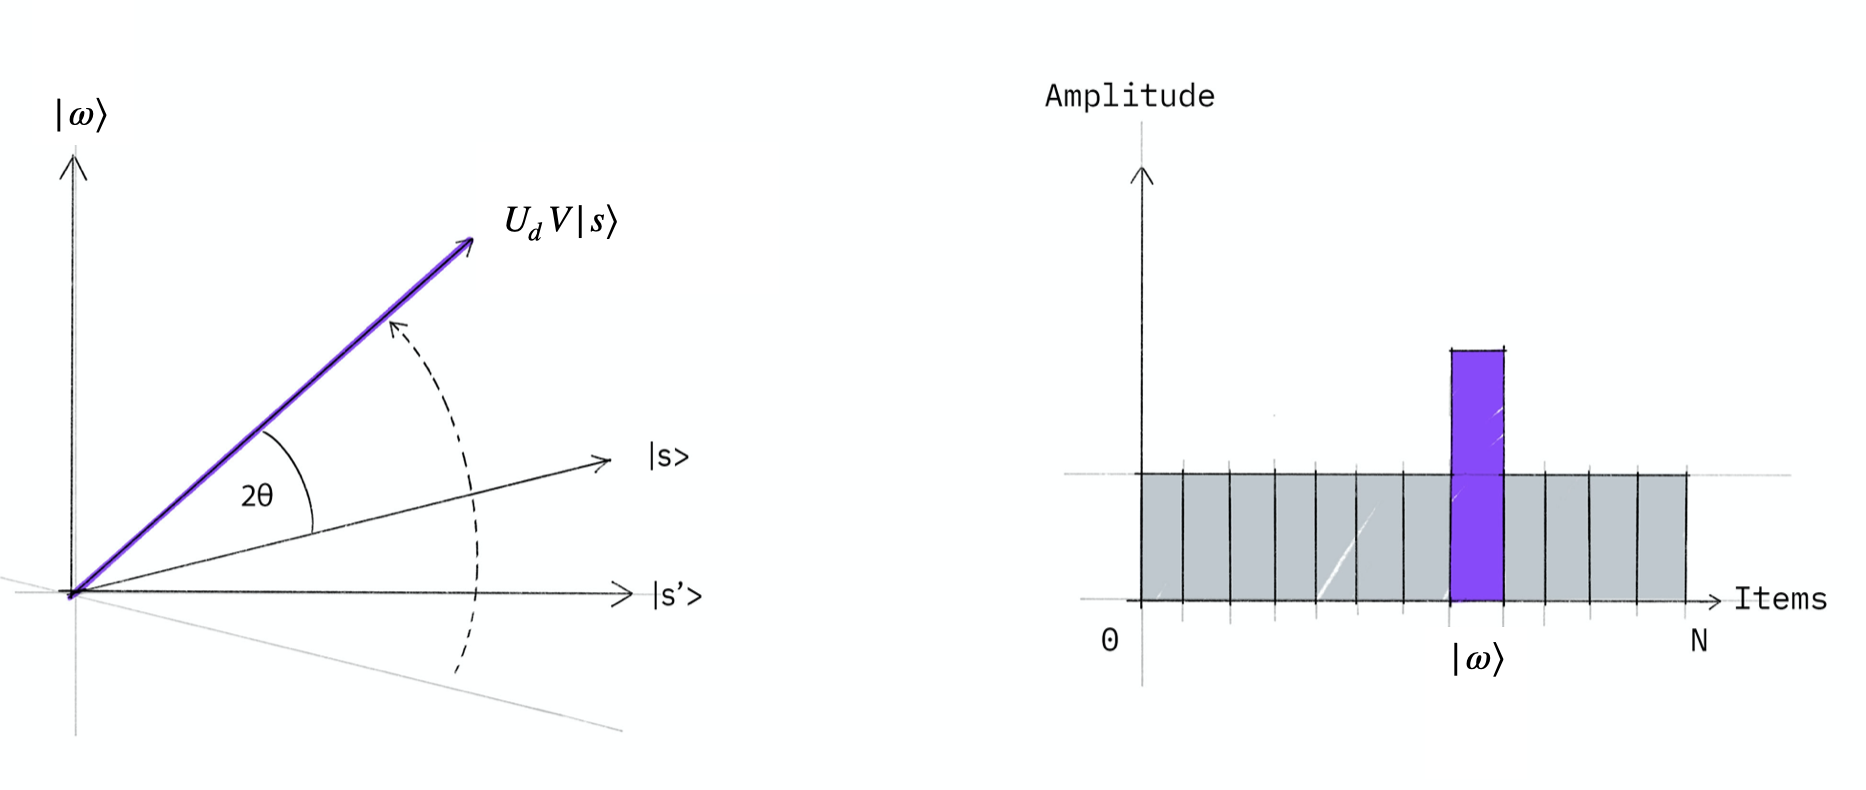

This is exactly what we want! $U_d$ actually stands for the diffusion operator rather than "difference", since it helps spread or diffuse the amplitude to the desired state $\vert \omega \rangle$.

## Exercise 2


The Grover iterator is given by the composition $U_d \, V$.

Check the amplification of the amplitude acting with $U_d \, V$ on the state $\vert{s}\rangle$, with our $\vert{\omega}\rangle = \vert101\rangle$.

You can exploit the already prebuilt circuits of the quantum oracle of the combination $101$.
To build $U_d$ consider that

$$ U_d = 2\vert{s}\rangle\langle{s}\vert - \mathbb{I} = H^{\otimes n} \big(2\vert{0}\rangle\langle{0}\vert - \mathbb{I}\big) H^{\otimes n} $$

and we know how to build $\mathbb {I}-2\vert  {\omega}\rangle \langle  {\omega} \vert $. A global phase is negligible.

Print the circuit.

Then check with the state vector the amplitude of the solution has has been amplified.



In [ ]:
NUM_QUBITS = 3
dev = qml.device("default.qubit", wires=NUM_QUBITS)

# your code here

In [ ]:
# this code is for the bar plot, as long as you correctly took the snapshots and gave the keys below

# again, print the snapshot dictionary
for k, result in results.items():
    print(f"\n{k}: {result}")

y1 = np.real(results["After applying the oracle"]) # KEY 1
y2 = np.real(results["After applying the diffusion operator"]) # KEY 2

bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y1))]

bar_width = 0.4

rect_1 = np.arange(0, len(y1))
rect_2 = [x + bar_width for x in rect_1]

plt.bar(
    rect_1,
    y1,
    width=bar_width,
    edgecolor="white",
    color = "#70CEFF",
    label="After applying the oracle",
)
plt.bar(
    rect_2,
    y2,
    width=bar_width,
    edgecolor="white",
    color = "#C756B2",
    label="After applying the diffusion operator",
)

plt.xticks(rect_1 + 0.2, bit_strings, rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")
# plt.axhline(y=0.0, color="k", linestyle="-")

plt.legend()
plt.show()


NameError: name 'results' is not defined

## Exercise 3


Using the results of the previous exercise, find out how many times to repeat $U_d V$ to maximize the probability of measuring $\vert{\omega}\rangle = \vert101\rangle$.


We can see how the $U_d V$ operator works as follows

$\vert{s}\rangle = \sin{\theta}\vert{\omega}\rangle + \cos{\theta}\vert{s'}\rangle → U_d V\vert {s}\rangle = \sin{3\theta}\vert{\omega}\rangle + \cos{3\theta}\vert{s'}\rangle$

In general it can be shown that $k$ iteration of the Grover step lead to:

$(U_d V)^k \vert{s}\rangle = \sin{\big[(2k+1)\theta}\big]\vert{\omega}\rangle + \cos{\big[(2k+1)\theta}\big]\vert{s'}\rangle$

Grover's algorithm ultimately consists of repeating the application of the $U_d V$ operator $k$ times.

Since $ \theta_R := 2\theta \sim \frac{2}{\sqrt{N}}$ then $k \sim \frac{\pi/2-\theta}{\theta_R}  \sim \frac{\pi}{4} \sqrt{N}$ for large $N \gg 1$.

Is this accurate for $N=8$? Try comparing with the exact values without approximations!

In [ ]:
# your code here

---

## Interlude: a practical formulation of the search problem

*"Using as precious a resource as qubits, however, merely to store classical information would be insanely extravagant, given our current or even our currently foreseeable ability to manufacture qubits."*

N. David Mermin, Quantum Computer Science, Chapter 4

> There is something important hidden under the carpet, **here**:
>
> The solution to this black-box search problem with a quantum algorithm enables to perform $O(\sqrt{N})$ queries to a **quantum oracle**
> in the framework of a probabilistic algorithm that finds the answer $\omega$ with high probability.


The quantum oracle is a much more demanding object to be constructed, compared to the classical oracle: in fact, it acts on the full Hilbert space and should be able to process any linear combination of classical string $x$, namely any n-qubit quantum state.

The comparison is usually made in terms of **complexity** cost between $N$ calls to the *classical* oracle $f(x)$ on **classical strings**, and $\sqrt{N}$ calls to the *quantum* oracle $V \left| \phi \right\rangle$ on generic **quantum states** . This is, at least, *problematic*, as one in general does not know how to build the quantum oracle $V$ without knowing a priori the solution  $\vert{\omega} \rangle$ (a.k.a. without cheating).

Let us see a practical formulation of the search problem. Reference: [SISSA notes](https://cm.sissa.it/phd/courses/seminar-series-quantum-computation-and-information) by G.E. Santoro (pag 85) and Mermin's book, Chapter 4.

In number theory, a fairly elementary results states that: if $p$ is **prime** and can be written as $p=4 k +1$ for some integer $k$, there exist two unique integers $a$, $b$ such that

$$
p = a^2 + b^2$$

Examples, with small numbers: $5 = 4+1$, $13 = 9+4$, $17 = 16+1$ and so on

**Problem**: given a large prime $p=4 k +1$, find $a$. Then $b = \sqrt{p-a^2}$.

Brute force: random testing of all integers $x$ from $1$ to $N \sim \sqrt{ \mathrm{int}\left(p/2\right)}$.

This is the oracle black-box:


<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1bIzDUEkL4hJywBnvACaG-qDNJQ-jdxX5" width="550"/>
</p>


Classically, it is trivial to check if $b$ is integer (namely, apply the classical oracle $f(x)$ to a classical candidate string).

But how do you construct $U_f$ and $V$?
If you could do it, you could have a quadratic advantage (only $\sqrt{N}$ calls of $V$) without any knowledge of number theory.

This is a serious question, I don't know if it possible to construct it. If you fine a way, let me know.

The Grover's algorithm is a beautiful conceptual milestone of quantum computing. It is still the subject of current research.
If you have a strong heart, you can check this recent paper: [link](https://arxiv.org/abs/2303.11317). However, the discussion is not over, I think...

---

### Multiple solutions

Let us now consider the case with multiple solutions, namely $1<M \ll N$.

We define the set of solutions as $\Omega = \{\omega_i\in\{0,1\}^n \vert i = 1,\dots,M\}$.
One can generalize Grover's algorithm in order to amplify the component of our starting state in superposition $\vert{s}\rangle$ onto the state with all solutions in uniform superposition:

$$\vert{\Omega}\rangle = \frac{1}{\sqrt{M}}\sum_{i=1}^{M}\vert{\omega}_i\rangle$$

The quantum oracle corresponding to this state can therefore be written as

$$ V = \mathbb{I} - 2\vert{\Omega}\rangle\langle{\Omega}\vert = \mathbb{I} - \frac{2}{M}\sum_{i= 1}^{M}\vert{\omega}_i\rangle\langle{\omega}_i\vert $$



The state $\vert{s}\rangle$ can therefore be written as

$$ \vert s \rangle = \sqrt{\frac{M}{N}}\vert {\Omega}\rangle + \sqrt{\frac{N-M}{N} }\vert {s'}\rangle $$



where $\vert s' \rangle$ is the projection of the initial state $\vert s \rangle$ onto the eigenspace of non-solutions in
$\Omega^c = \{0,1\}^n \backslash \Omega \equiv \{y_i\}_{i=1}^{N-M}$:


$$ \vert {s'}\rangle = \frac{1}{\sqrt{N-M}} \sum_{i=1}^{N-M} \vert{y}_i \rangle $$


So we can use the same procedure utilized for $M=1$, but in this case we have:

$$\sin{\theta} = \sqrt{\frac{M}{N}} \implies \theta \sim \sqrt{\frac{M}{N}} \hspace{2mm} \text{for} \hspace{2mm} N \gg M$$  

How does this reflect in the number of repetitions of the operator $U_d V$?


## Exercise 4

Solve a 'real' search problem. Consider the quantum oracle written below. The exercise consists in using Grover's algorithm to find solutions such that $U_f\vert\mathbf{\omega}_i\rangle = -\vert\mathbf{\omega}_i\rangle$.

Now the oracle is truly a black box! Clearly, it can be reverse engineered, by inspecting the circuit

Find the optimal number of iterations.

In [ ]:
def oracle_ex4():

    qml.Hadamard(wires=[4])
    qml.MultiControlledX(control_wires=[0,1,2,3], wires=[4])
    qml.Hadamard(wires=[4])
    qml.Barrier(wires=range(0,5), only_visual=True) # graphical tool with no effect on compilation

    qml.Hadamard(wires=[4])
    qml.MultiControlledX(control_wires=[0,2,3], wires=[4])
    qml.Hadamard(wires=[4])
    qml.Barrier(wires=range(0,5), only_visual=True) # graphical tool with no effect on compilation

    qml.Hadamard(wires=[2])
    qml.MultiControlledX(control_wires=[0,1], wires=[2])
    qml.Hadamard(wires=[2])
    qml.Barrier(wires=range(0,5), only_visual=True) # graphical tool with no effect on compilation

    qml.Hadamard(wires=[2])
    qml.MultiControlledX(control_wires=[0,3,4], wires=[2])
    qml.Hadamard(wires=[2])
    qml.Barrier(wires=range(0,5), only_visual=True) # graphical tool with no effect on compilation

# Use also:
def initialization(n):
    for i in range(0, n): qml.Hadamard(wires=[i])

def diffusion(n):
    for i in range(0, n): qml.Hadamard(wires=[i])
    for i in range(0, n): qml.PauliX(wires=[i])
    qml.Hadamard(wires=[n-1])
    qml.MultiControlledX(control_wires=list(range(0,n-1)), wires=[n-1])
    qml.Hadamard(wires=[n-1])
    qml.Barrier(wires=range(0,5), only_visual=True) # graphical tool with no effect on compilation
    for i in range(0, n): qml.PauliX(wires=[i])
    for i in range(0, n): qml.Hadamard(wires=[i])


In [ ]:
# your code here

## Exercise 5

No code neeeded:
What happens if $M < N$ but of the same order of magnitude? Do you see a simple way out?

Ref: Inspired also by this Pennylane DEMO [notebook](https://pennylane.ai/qml/demos/tutorial_grovers_algorithm/).

<div class="alert-block alert-success">
	&#10003; <b>Well done!</b> Lesson number 3 is over.
</div>